<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook <br>with pre-trained embeddings and FAISS</b> </font><br>
    <font size="6"><b>Abt - Buy</b> </font>
   <hr>
</div>

In [1]:
!python --version

Python 3.9.1


In [10]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/test/ccer/abt_100.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/test/ccer/buy_100.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/test/ccer/gt_100.csv", sep='|', engine='python')

# d1 = pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
# d2 = pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
# gt = pd.read_csv("./data/ccer/D2/gt.csv", sep='|', engine='python')


data = Data(dataset_1=d1,
            # attributes_1=['id','name','description'],
            id_column_name_1='id',
            dataset_2=d2,
            # attributes_2=['id','name','description'],
            id_column_name_2='id',
            ground_truth=gt)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
gt.head(5)

,D1,D2
0,206,216
1,60,46
2,182,160
3,428,223
4,816,789


# Block Building

## FAISS

faiss.IndexIVFFlat is an implementation of an inverted file index with coarse quantization. This index is used to efficiently search for nearest neighbors of a query vector in a large dataset of vectors. Here's a brief explanation of the parameters used in this index:

- `d`: The dimension of the input vectors. Each input vector should have d elements.
- `nlist`: The number of cells (or clusters) to divide the dataset into. This determines the number of inverted lists in the index, and hence the maximum number of vectors that can be stored in the index. Larger values of nlist will generally result in more accurate search results, but may also increase the memory requirements of the index and the time required to perform searches.
- `quantizer`: An instance of a quantizer object that is used to compress the vectors before they are added to the index. The quantizer object should implement a train method that learns the quantization function from a set of input vectors, and a compress method that compresses a vector into an integer code. FAISS provides several built-in quantizer objects, such as IndexFlatL2 and IndexScalarQuantizer.
- `metric`: The distance metric used to measure the similarity between vectors. The metric should be one of the strings defined in the faiss.METRIC_TYPES list, such as "l2" for Euclidean distance or "ip" for inner product.
- `nprobe`: The number of cells (or clusters) to search during a query. This parameter determines the tradeoff between accuracy and speed during searches. Larger values of nprobe will generally result in more accurate search results, but may also increase the time required to perform searches.



In [55]:
from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

In [92]:
emb = EmbeddingsNNBlockBuilding(vectorizer='st5',
                                similarity_search='faiss')
blocks, g = emb.build_blocks(data, 
                          top_k=15,
                          load_embeddings_if_exist=False,
                          save_embeddings=False,
                         with_entity_matching=True)

Embeddings-NN Block Building [st5, faiss]:   0%|          | 0/200 [00:00<?, ?it/s]

Device selected:  cpu


In [95]:
emb.evaluate(blocks, with_classification_report=True, with_stats=True)

***************************************************************************************************************************
                                         Μethod:  Embeddings-NN Block Building
***************************************************************************************************************************
Method name: Embeddings-NN Block Building
Parameters: 
	Vectorizer: st5
	Similarity-Search: faiss
	Top-K: 15
	Vector size: 768
Runtime: 81.1516 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      1.63% 
	Recall:       100.00%
	F1-score:       3.21%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 49
	False positives: 2951
	True negatives: 7049
	False negatives: 0
	Total comparisons: 3000
─────────────────────────────────────────────────────────

{'Precision %': 1.633333333333333,
 'Recall %': 100.0,
 'F1 %': 3.2141685798622497,
 'True Positives': 49,
 'False Positives': 2951,
 'True Negatives': 7049,
 'False Negatives': 0}

In [97]:
from pyjedai.matching import EntityMatching

EM = EntityMatching(similarity_threshold=0.0)
EM.data = data
EM.evaluate(g)

***************************************************************************************************************************
                                         Μethod:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Tokenizer: white_space_tokenizer
	Metric: dice
	Similarity Threshold: 0.0
Runtime: 0.0000 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      3.27% 
	Recall:       100.00%
	F1-score:       6.33%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 3.266666666666666,
 'Recall %': 100.0,
 'F1 %': 6.3266623628147185,
 'True Positives': 49,
 'False Positives': 1451,
 'True Negatives': 8549,
 'False Negatives': 0}

# Entity Matching

In [105]:
from pyjedai.matching import EntityMatching

In [106]:
EM = EntityMatching(metric='cosine_vector_similarity',
                    similarity_threshold=0.0)

pairs_graph = EM.predict(blocks,
                         data,
                         tqdm_disable=True,
                         vectors_d1=emb.vectors_1,
                         vectors_d2=emb.vectors_2)

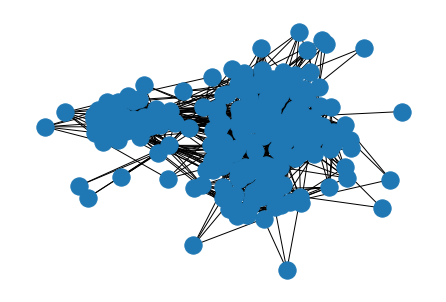

In [ ]:
draw(pairs_graph)

In [107]:
EM.evaluate(pairs_graph)

***************************************************************************************************************************
                                         Μethod:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Tokenizer: white_space_tokenizer
	Metric: cosine_vector_similarity
	Similarity Threshold: 0.0
Runtime: 0.6398 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      3.27% 
	Recall:       100.00%
	F1-score:       6.33%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 3.266666666666666,
 'Recall %': 100.0,
 'F1 %': 6.3266623628147185,
 'True Positives': 49,
 'False Positives': 1451,
 'True Negatives': 8549,
 'False Negatives': 0}

Distribution-% of predicted scores:  [0.0, 0.0, 0.0, 0.0, 0.0, 22.866666666666667, 49.6, 17.133333333333333, 9.466666666666667, 0.9333333333333335]


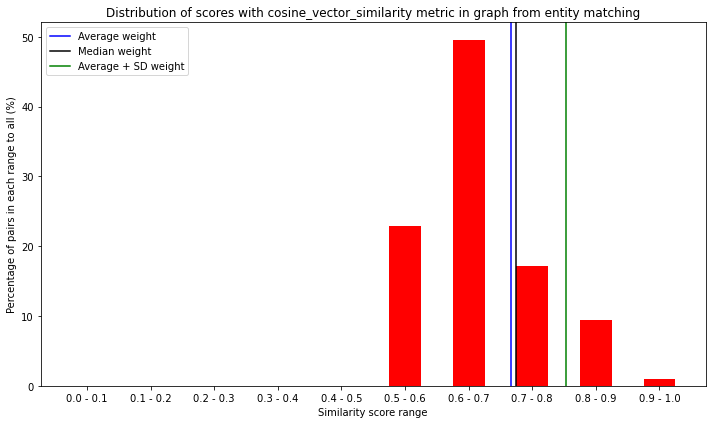

In [108]:
EM.plot_distribution_of_scores()

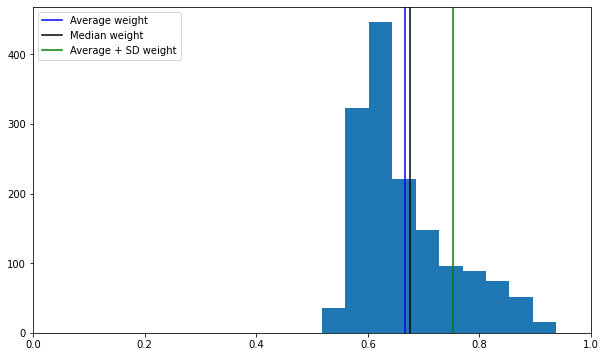

In [78]:
EM.plot_distribution_of_all_weights()

Distribution-% of predicted scores:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.081632653061225, 71.42857142857143, 24.489795918367346]


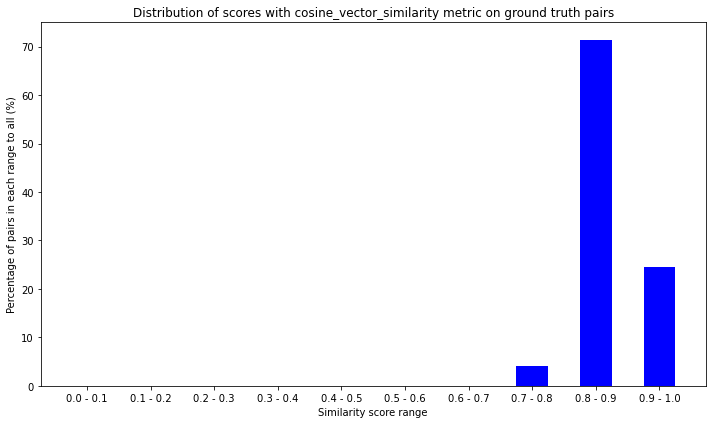

In [79]:
EM.plot_gt_distribution_of_scores()

In [80]:
EM.get_weights_avg()

0.6661644401152929

In [81]:
EM.get_weights_median()

0.67512095

In [82]:
EM.get_weights_standard_deviation()

0.08614566635704156

# Entity Clustering

In [98]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [102]:
ccc = UniqueMappingClustering()
clusters = ccc.process(g, data, similarity_threshold=0.78)

In [100]:
ccc.report()

Method name: Unique Mapping Clustering
Method info: Prunes all edges with a weight lower than t, sorts the remaining ones indecreasing weight/similarity and iteratively forms a partition forthe top-weighted pair as long as none of its entities has alreadybeen matched to some other.
Parameters:  None
Runtime: 0.0060 seconds


In [103]:
ccc.evaluate(clusters, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Unique Mapping Clustering
***************************************************************************************************************************
Method name: Unique Mapping Clustering
Parameters: 
Runtime: 0.0070 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     31.91% 
	Recall:        30.61%
	F1-score:      31.25%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 15
	False positives: 32
	True negatives: 9934
	False negatives: 34
	Total comparisons: 47
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 31.914893617021278,
 'Recall %': 30.612244897959183,
 'F1 %': 31.25,
 'True Positives': 15,
 'False Positives': 32,
 'True Negatives': 9934,
 'False Negatives': 34}